In [27]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

### Model Testing

Number of faces detected: 1


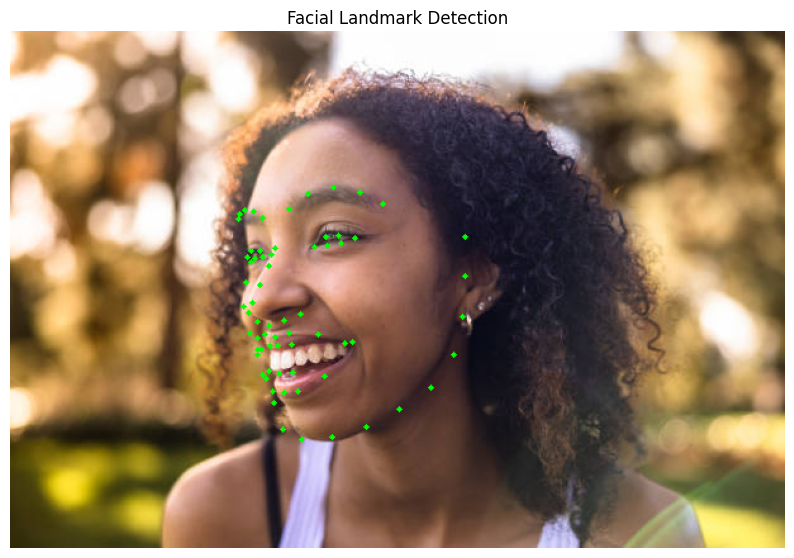

In [28]:
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
IMAGE_PATH = "./image.png"

# Initialize dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

# Load the image
image = cv2.imread(IMAGE_PATH)
img_copy_1 = image.copy()
left_half = image.copy()
right_half = image.copy()
if image is None:
    print(f"Image not found at {IMAGE_PATH}")
    exit()

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = detector(gray)
print(f"Number of faces detected: {len(faces)}")

for face in faces:
    landmarks = predictor(gray, face)

    # Loop through each landmark point
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

# Convert image from BGR to RGB for displaying with Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.title("Facial Landmark Detection")
plt.axis('off')
plt.show()


### Identifying Nose and Eyes Midpoint

Value of d: 55.60575509783138
Value of D: 36.65573770491803


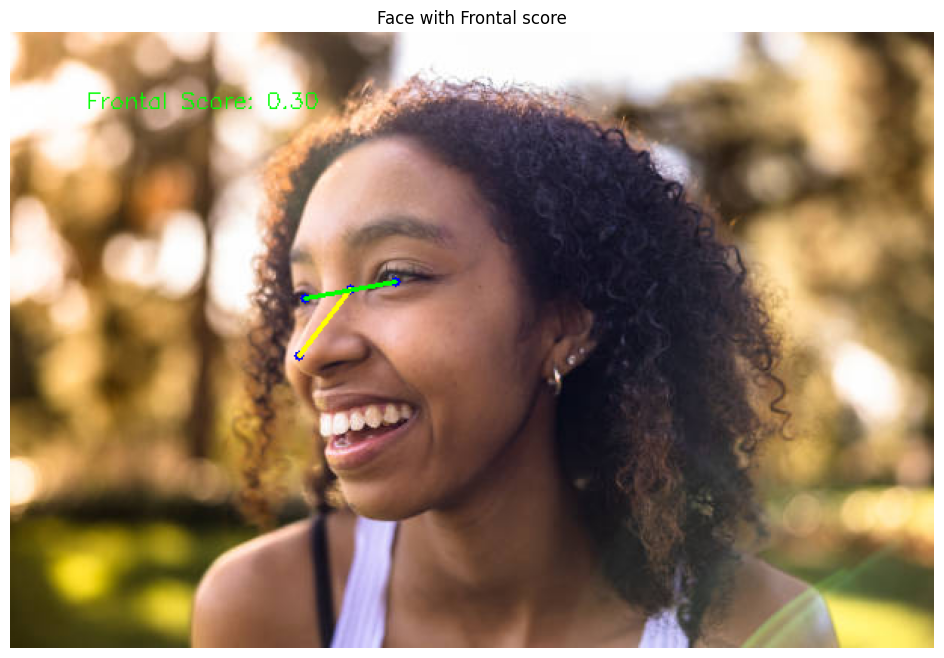

In [29]:
for face in faces:
    landmarks = predictor(gray, face)

    # Extract eye landmarks
    left_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
    right_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]

    # Calculate the center (midpoint) of each eye
    left_eye_center = np.mean(left_eye_points, axis=0).astype(int)
    right_eye_center = np.mean(right_eye_points, axis=0).astype(int)

    # Calculate the midpoint between the two eyes
    eyes_midpoint = (
        (left_eye_center[0] + right_eye_center[0]) // 2,
        (left_eye_center[1] + right_eye_center[1]) // 2
    )

    # Nose tip
    nose_tip = (landmarks.part(30).x, landmarks.part(30).y)

    # Calculate distances
    d = np.linalg.norm(np.array(nose_tip) - np.array(eyes_midpoint))
    line_vector = np.array(right_eye_center) - np.array(left_eye_center)
    line_length = np.linalg.norm(line_vector)
    perpendicular_vector = np.array([-line_vector[1], line_vector[0]])
    D = abs(np.dot((np.array(nose_tip) - np.array(left_eye_center)), perpendicular_vector / line_length))
    print("Value of d:",d)
    print("Value of D:",D)

    # Calculate frontal score
    frontal_score = 1 / (1 + (d / D) ** 2)

    # Draw points and lines
    cv2.circle(img_copy_1, nose_tip, 3, (255, 0, 0), -1)
    cv2.circle(img_copy_1, tuple(left_eye_center), 3, (255, 0, 0), -1)
    cv2.circle(img_copy_1, tuple(right_eye_center), 3, (255, 0, 0), -1)
    cv2.circle(img_copy_1, tuple(eyes_midpoint), 3, (255, 0, 0), -1)
    cv2.line(img_copy_1, nose_tip, eyes_midpoint, (0, 255, 255), 2)
    cv2.line(img_copy_1, tuple(left_eye_center), tuple(right_eye_center), (0, 255, 0), 2)

    # Display frontal score on the image
    cv2.putText(
        img_copy_1,
        f"Frontal Score: {frontal_score:.2f}",
        (50, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        1
    )

# Convert images from BGR to RGB for displaying with Matplotlib
img_copy_1_rgb = cv2.cvtColor(img_copy_1, cv2.COLOR_BGR2RGB)

# Display both images
plt.figure(figsize=(20, 8))

# Image showing all landmarks
plt.imshow(img_copy_1_rgb)
plt.title("Face with Frontal score")
plt.axis('off')

plt.show()

Number of faces detected: 1


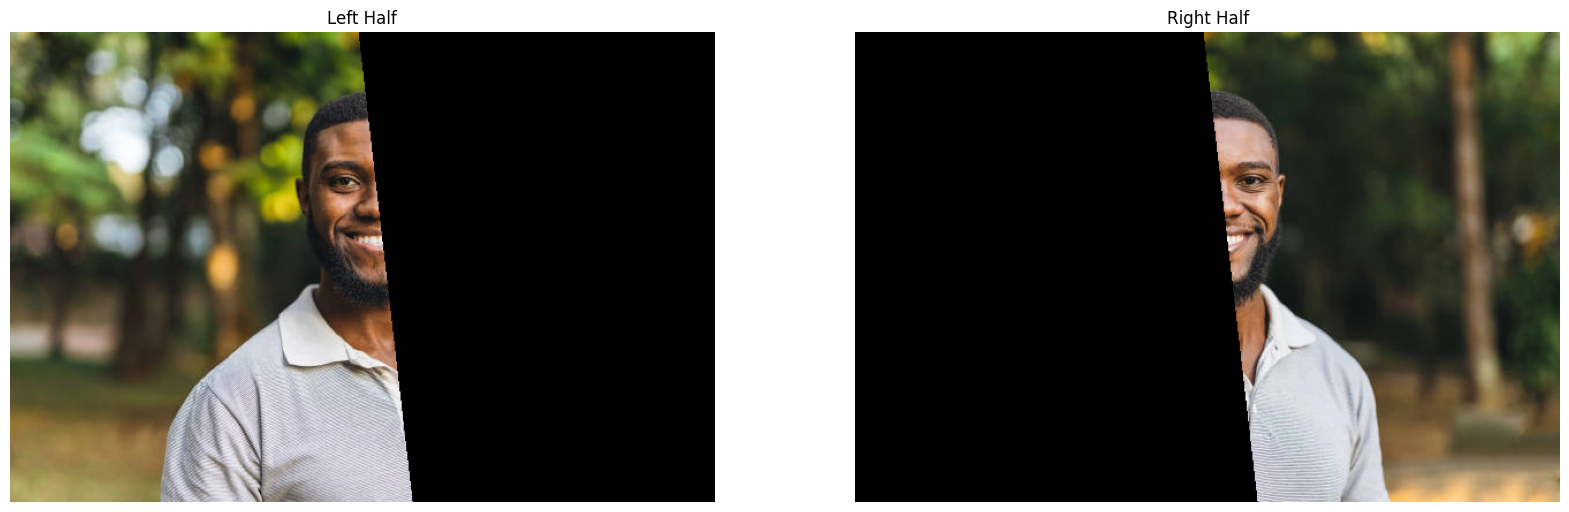

In [30]:
import cv2
import matplotlib.pyplot as plt
import dlib
import numpy as np

# Paths
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
IMAGE_PATH = "./img.png"

# Initialize dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

# Load the image
image = cv2.imread(IMAGE_PATH)
if image is None:
    print(f"Image not found at {IMAGE_PATH}")
    exit()

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = detector(gray)
print(f"Number of faces detected: {len(faces)}")

for face in faces:
    landmarks = predictor(gray, face)

    # Extract eye landmarks
    left_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
    right_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]

    # Calculate the center (midpoint) of each eye
    left_eye_center = np.mean(left_eye_points, axis=0).astype(int)
    right_eye_center = np.mean(right_eye_points, axis=0).astype(int)

    # Calculate the midpoint between the two eyes
    eyes_midpoint = (
        (left_eye_center[0] + right_eye_center[0]) // 2,
        (left_eye_center[1] + right_eye_center[1]) // 2
    )

    # Nose tip
    nose_tip = (landmarks.part(30).x, landmarks.part(30).y)

    # Create masks for left and right halves
    height, width, _ = image.shape
    left_mask = np.zeros((height, width), dtype=np.uint8)
    right_mask = np.zeros((height, width), dtype=np.uint8)

    # Define the line separating left and right
    line_vector = np.array(eyes_midpoint) - np.array(nose_tip)
    perpendicular_vector = np.array([-line_vector[1], line_vector[0]])

    for y in range(height):
        for x in range(width):
            point_vector = np.array([x, y]) - np.array(nose_tip)
            side = np.dot(point_vector, perpendicular_vector)
            if side < 0:
                left_mask[y, x] = 255
            else:
                right_mask[y, x] = 255

    # Create left and right images
    left_image = cv2.bitwise_and(image, image, mask=left_mask)
    right_image = cv2.bitwise_and(image, image, mask=right_mask)

    # Convert images from BGR to RGB for displaying with Matplotlib
    left_rgb = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
    right_rgb = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)

    # Display the results
    plt.figure(figsize=(20, 8))

    # Left part
    plt.subplot(1, 2, 1)
    plt.imshow(left_rgb)
    plt.title("Left Half")
    plt.axis('off')

    # Right part
    plt.subplot(1, 2, 2)
    plt.imshow(right_rgb)
    plt.title("Right Half")
    plt.axis('off')

    plt.show()


Number of faces detected: 1
Left Half Average Coordinates: [162 208]
Right Half Average Coordinates: [468 197]


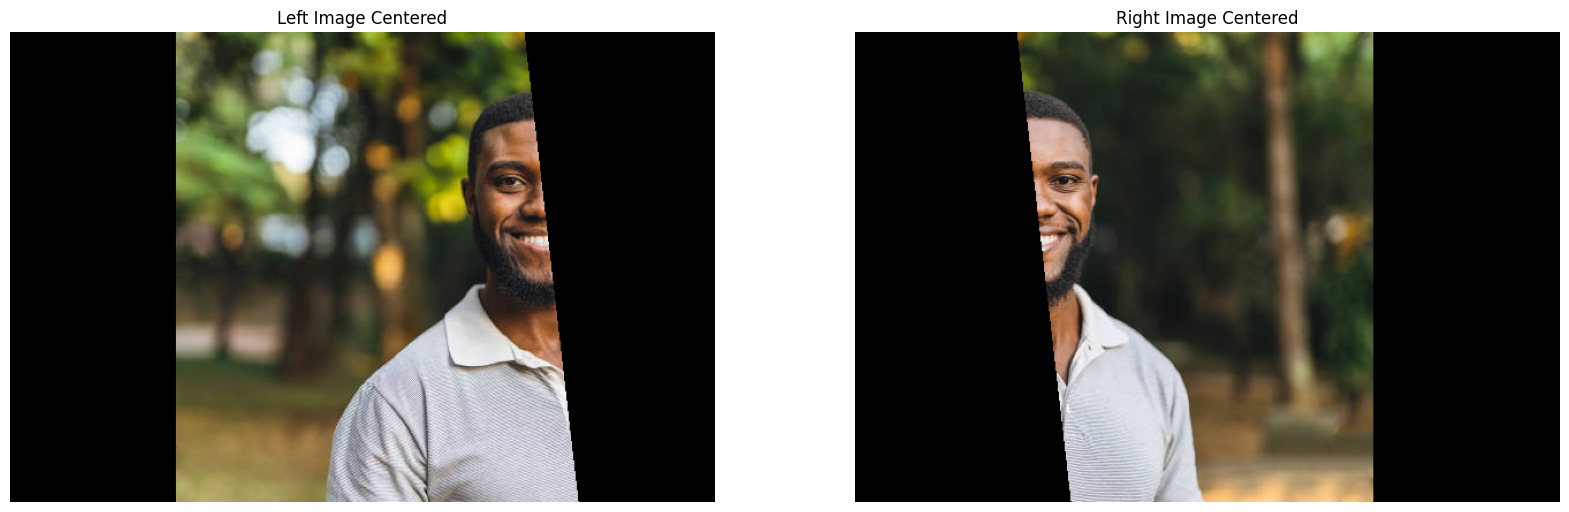

In [31]:
import cv2
import matplotlib.pyplot as plt
import dlib
import numpy as np

# Paths
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
IMAGE_PATH = "./img.png"

# Initialize dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

# Load the image
image = cv2.imread(IMAGE_PATH)
if image is None:
    print(f"Image not found at {IMAGE_PATH}")
    exit()

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = detector(gray)
print(f"Number of faces detected: {len(faces)}")

for face in faces:
    landmarks = predictor(gray, face)

    # Extract eye landmarks
    left_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
    right_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]

    # Calculate the center (midpoint) of each eye
    left_eye_center = np.mean(left_eye_points, axis=0).astype(int)
    right_eye_center = np.mean(right_eye_points, axis=0).astype(int)

    # Calculate the midpoint between the two eyes
    eyes_midpoint = (
        (left_eye_center[0] + right_eye_center[0]) // 2,
        (left_eye_center[1] + right_eye_center[1]) // 2
    )

    # Nose tip
    nose_tip = (landmarks.part(30).x, landmarks.part(30).y)

    # Create masks for left and right halves
    height, width, _ = image.shape
    left_mask = np.zeros((height, width), dtype=np.uint8)
    right_mask = np.zeros((height, width), dtype=np.uint8)

    # Define the line separating left and right
    line_vector = np.array(eyes_midpoint) - np.array(nose_tip)
    perpendicular_vector = np.array([-line_vector[1], line_vector[0]])

    for y in range(height):
        for x in range(width):
            point_vector = np.array([x, y]) - np.array(nose_tip)
            side = np.dot(point_vector, perpendicular_vector)
            if side < 0:
                left_mask[y, x] = 255
            else:
                right_mask[y, x] = 255

    # Create left and right images
    left_image = cv2.bitwise_and(image, image, mask=left_mask)
    right_image = cv2.bitwise_and(image, image, mask=right_mask)

    # Calculate average positions of non-zero pixels for each half
    left_nonzero = cv2.findNonZero(left_mask)
    right_nonzero = cv2.findNonZero(right_mask)

    if left_nonzero is not None:
        left_avg = np.mean(left_nonzero, axis=0).astype(int)[0]
        diff_left = width//2 - left_avg[0]
        print(f"Left Half Average Coordinates: {left_avg}")

    if right_nonzero is not None:
        right_avg = np.mean(right_nonzero, axis=0).astype(int)[0]
        diff_right = right_avg[0] - width//2
        print(f"Right Half Average Coordinates: {right_avg}")

    # Apply affine transformation to shift images
    # Define the transformation matrix for the left image (shift right)
    M_left = np.float32([[1, 0, diff_left], [0, 1, 0]])

    # Define the transformation matrix for the right image (shift left)
    M_right = np.float32([[1, 0, -diff_right], [0, 1, 0]])

    # Apply the transformations
    left_image_shifted = cv2.warpAffine(left_image, M_left, (width, height))
    right_image_shifted = cv2.warpAffine(right_image, M_right, (width, height))

    # Display the shifted images
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(left_image_shifted, cv2.COLOR_BGR2RGB))
    plt.title("Left Image Centered")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(right_image_shifted, cv2.COLOR_BGR2RGB))
    plt.title("Right Image Centered")
    plt.axis('off')

    plt.show()
